In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Dataset generattion

I generated my dastet using a set of python scirpts rather than  a jupyter notebook. Below are the contents of these scirpts. I have not tested them on a jupyter notebbok

### 1.1 Generate random generator matrices

First I generated one file for each unique n,k combination that contains a set of random generator matrices

In [ ]:
import numpy as np
import math
import pickle
import gzip
import os
from concurrent.futures import ProcessPoolExecutor
def generate_random_P(n, k, existing_Ps, num_samples):
    """
    Generates unique random k x (n-k) matrices P with real values bounded between -100 and 100.
    The number of unique matrices to generate is num_samples / (n-k)!.
    Matrices with the same columns but in a different order are considered duplicates.
    """
    target_count = num_samples
    generated_count = 0

    while generated_count < target_count:
        P = np.random.uniform(-100, 100, (k, n - k))  # Real-valued matrix
        # Check for duplicates considering column permutations
        P_columns = frozenset(tuple(col) for col in P.T)
        if P_columns not in existing_Ps:
            existing_Ps.add(P_columns)
            generated_count += 1
            yield P

def construct_generator_matrix(n, k, P):
    """
    Constructs the systematic k×n generator matrix G given the k×(n−k) matrix P.
    """
    if P.shape != (k, n - k):
        raise ValueError(f"P must have shape ({k}, {n-k}), but got {P.shape}")

    I_k = np.eye(k, dtype=P.dtype)
    G = np.concatenate((I_k, P), axis=1)
    return G

In [ ]:
def generate_dataset(n, k, num_samples, max_m_value):
    """
    Generates a dataset of random P matrices and saves the generator matrices.
    Each row corresponds to one generator matrix and its associated max_m_value.
    Saves the dataset to a compressed file named G_n_k.
    """
    dataset = []
    existing_Ps = set()

    for P in generate_random_P(n, k, existing_Ps, num_samples):
        G = construct_generator_matrix(n, k, P)
        dataset.append({
            "generator_matrix": G.tolist(),
            "max_m_value": max_m_value
        })

    # Ensure the folder exists
    os.makedirs("generator_matrices", exist_ok=True)

    # Save the dataset to a compressed file
    file_name = f"generator_matrices/G_{n}_{k}_maxM{max_m_value}.pkl.gz"
    with gzip.open(file_name, 'wb') as f:
        pickle.dump(dataset, f)

    print(f"Dataset saved to {file_name}")
    return file_name

def process_combination(args):
    """
    Helper function to process a single combination of (n, k, max_m_value).
    """
    n, k, max_m_value, num_samples = args
    print(f"Generating dataset for n={n}, k={k}, max_m_value={max_m_value}...")
    return generate_dataset(n, k, num_samples, max_m_value)

In [ ]:
combinations = [
    (9, 4, 5),
    (9, 5, 4),
    (9, 6, 3),
    (10, 4, 6),
    (10, 5, 5),
    (10, 6, 6)
]
num_samples = 10000

# Prepare arguments for multiprocessing
args_list = [(n, k, max_m_value, num_samples) for n, k, max_m_value in combinations]

# Use ProcessPoolExecutor with max_workers=4
with ProcessPoolExecutor(max_workers=4) as executor:
    results = list(executor.map(process_combination, args_list))

combinations = [
        (9, 4, 5, 35000), # n,k,max_m_value,num_samples
        (9, 5, 4, 60000),
        (9, 6, 3, 60000),
        (10, 4, 6, 35000),
        (10, 5, 5, 35000),
        (10, 6, 6, 35000)
    ]

for n, k, max_m_value, num_samples in combinations:
    process_combination(n, k, num_samples, max_m_value)

print("All datasets have been generated.")

### 1.2 Solving for m-heights

LP formulation for a given tuple

In [ ]:
import sys
import pickle
import gzip
import os
import numpy as np
from itertools import combinations, product
from ortools.linear_solver import pywraplp
import time
import math
from concurrent.futures import ProcessPoolExecutor

def solve_m_height_lp_google(G, a, b, X, psi, debug=False):
    """
    Solves the m-height LP problem for a given tuple (a, b, X, psi) using Google's OR-Tools.
    """
    k, n = G.shape
    Y = list(set(range(n)) - set(X) - {a, b})  # Y = [n] \ X \ {a, b}
    tau = [a] + sorted(X) + [b] + sorted(Y)
    tau_inv = {tau[j]: j for j in range(n)}  # Inverse of τ

    solver = pywraplp.Solver.CreateSolver('GLOP')
    if not solver:
        raise Exception("Solver not created. Ensure OR-Tools is installed correctly.")

    u = [solver.NumVar(-solver.infinity(), solver.infinity(), f'u_{i}') for i in range(k)]

    objective = solver.Objective()
    for i in range(k):
        coefficient = float(psi[0] * G[i, a])
        objective.SetCoefficient(u[i], coefficient)
    objective.SetMaximization()

    for j in X:
        j_tau = tau_inv[j]
        constraint1 = solver.Constraint(-solver.infinity(), 0)
        constraint2 = solver.Constraint(-solver.infinity(), -1)
        for i in range(k):
            constraint1.SetCoefficient(u[i], float(psi[j_tau] * G[i, j] - psi[0] * G[i, a]))
            constraint2.SetCoefficient(u[i], float(-psi[j_tau] * G[i, j]))

    eq_constraint = solver.Constraint(1, 1)
    for i in range(k):
        eq_constraint.SetCoefficient(u[i], float(G[i, b]))

    for j in Y:
        constraint1 = solver.Constraint(-solver.infinity(), 1)
        constraint2 = solver.Constraint(-solver.infinity(), 1)
        for i in range(k):
            constraint1.SetCoefficient(u[i], float(G[i, j]))
            constraint2.SetCoefficient(u[i], float(-G[i, j]))

    status = solver.Solve()
    if status == pywraplp.Solver.INFEASIBLE:
        return 0
    elif status == pywraplp.Solver.UNBOUNDED:
        return float('inf')
    else:
        return objective.Value()

Compute all m-heights  upto max m-value for a given Generator matrix

In [ ]:
def compute_m_heights(G, lp_solve_function, max_m_value, debug=False):
    """
    Computes all m-heights of the code defined by the generator matrix G.
    """
    n = G.shape[1]
    m_heights = []

    for m in range(1, max_m_value + 1):
        max_hm = float('-inf')
        for a, b in product(range(n), repeat=2):
            if a != b:
                for X in combinations(set(range(n)) - {a, b}, m - 1):
                    for psi in product([-1, 1], repeat=m):
                        result = lp_solve_function(G, a, b, list(X), list(psi), debug=debug)
                        max_hm = max(max_hm, result)
        m_heights.append(max_hm)
        if max_hm == float('inf'):
            break

    # Fill remaining m-heights with infinity
    for m in range(len(m_heights), min(max_m_value + 1, n)):
        m_heights.append(float('inf'))

    return m_heights

Stepping through the generated dataset and solving m-heights for all the Generator matrices in the dataset. Each n,k combination has its own dataset. The dataset is processed in batches to reduce mmeory usage and easy pickup on crash

In [ ]:
def process_sample(sample):
    """
    Processes a single generator matrix sample, computes m-heights, and returns the result.
    """
    G = np.array(sample["generator_matrix"], dtype=np.float32)
    max_m_value = sample["max_m_value"]

    k = G.shape[0]
    P = G[:, k:]  # Remove the kxk identity matrix from the front of G
    print("Started processing sample...")
    m_heights = compute_m_heights(G, solve_m_height_lp_google, max_m_value)
    print("Finished processing sample.")
    return {
        "n": G.shape[1],
        "k": G.shape[0],
        "P_matrix": P.tolist(),
        "m_heights": m_heights
    }

def process_batch(batch_data):
    """
    Processes a batch of generator matrix samples in parallel and returns the results.
    """
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_sample, batch_data))
    return results

def process_dataset(input_file, batch_size, num_workers, output_folder):
    """
    Processes a generator matrix dataset in batches using multiprocessing,
    computes m-heights for each sample in parallel within a batch, and saves the results.
    """
    print(f"Starting dataset processing: {input_file}, batch size: {batch_size}, workers: {num_workers}, output folder: {output_folder}")
    try:
        with gzip.open(input_file, 'rb') as f:
            dataset = pickle.load(f)

        if not dataset:
            print("The dataset is empty.")
            return

        # Create a subfolder for this input file under the output folder
        input_file_name = os.path.splitext(os.path.basename(input_file))[0]
        subfolder = os.path.join(output_folder, input_file_name)
        os.makedirs(subfolder, exist_ok=True)

        total_samples = len(dataset)
        running_total = 0

        # Split the dataset into batches
        batches = [dataset[i:i + batch_size] for i in range(0, total_samples, batch_size)]

        for batch_number, batch_data in enumerate(batches, start=1):
            print(f"Processing batch {batch_number} with {len(batch_data)} samples...")

            # Process the batch in parallel
            results = process_batch(batch_data)

            # Save the batch results to a file in the subfolder
            output_file = os.path.join(subfolder, f"batch_{batch_number}.pkl.gz")
            with gzip.open(output_file, 'wb') as f:
                pickle.dump(results, f)

            running_total += len(batch_data)
            print(f"Processed batch {batch_number}, running total: {running_total}/{total_samples}")

        print(f"All batches for {input_file} have been processed and saved in {subfolder}.")

    except FileNotFoundError:
        print(f"Error: File not found: {input_file}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
input_files = [
    'generator_matrices/G_9_4_maxM5.pkl.gz',
    'generator_matrices/G_9_5_maxM4.pkl.gz',
    'generator_matrices/G_9_6_maxM3.pkl.gz',
    'generator_matrices/G_10_4_maxM6.pkl.gz',
    'generator_matrices/G_10_5_maxM5.pkl.gz',
    'generator_matrices/G_10_6_maxM6.pkl.gz'
]
# Process each input file
for input_file in input_files:
    process_dataset(input_file, batch_size = 100, num_workers = 4, output_folder= 'samples')


Combining all batches into one training dataset per n,k combination

In [ ]:
def combine_batches(samples_dirs, output_dir):
    """
    Combines batches from multiple samples directories into a single output directory.

    Args:
        samples_dirs (list): List of directories containing the samples.
        output_dir (str): Directory where the combined datasets will be saved.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Collect all unique dataset subfolder names
    dataset_names = set()
    for samples_dir in samples_dirs:
        for subfolder in os.listdir(samples_dir):
            dataset_names.add(subfolder)

    print(f"Found dataset names: {dataset_names}")
    # Process each dataset
    for dataset_name in dataset_names:
        combined_batches = []
        for samples_dir in samples_dirs:
            dataset_path = os.path.join(samples_dir, dataset_name)
            if os.path.exists(dataset_path) and os.path.isdir(dataset_path):
                for batch_file in sorted(os.listdir(dataset_path)):
                    batch_path = os.path.join(dataset_path, batch_file)
                    if batch_file.endswith(".pkl.gz"):
                        with gzip.open(batch_path, 'rb') as f:
                            batch_data = pickle.load(f)
                            combined_batches.extend(batch_data)

        # Save the combined dataset
        # output_dataset_path = os.path.join(output_dir, dataset_name)
        # os.makedirs(output_dataset_path, exist_ok=True)
        output_file = os.path.join(output_dir, dataset_name + "gz")
        with gzip.open(output_file, 'wb') as f:
            pickle.dump(combined_batches, f)
            # Print the size of the combined dataset
            print(f"Size of combined dataset '{dataset_name}': {len(combined_batches)} samples saved to {output_file}")
        # print(f"Combined dataset '{dataset_name}' saved to {output_file}")

In [ ]:
# List of directories containing the samples
samples_dirs = ["samples" ]
# Output directory for combined datasets
output_dir = "samples_combined"

combine_batches(samples_dirs, output_dir)

## 2. Model Training

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pickle
import gzip
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

###2.1 Custom training pipeline
A custom class to encapsulate the training pipeline. For each n,k commbination, this class encapsulates the steps to laod and preprocess the input dataset; compile, train and test tthe model

In [3]:
class CustomModel:
    def __init__(self, n, k, max_m_value):
        self.n = n
        self.k = k
        self.max_m_value = max_m_value

        self.P_matrices = None
        self.m_heights = None
        self.P_matrices_train = None
        self.P_matrices_test = None
        self.P_matrices_val = None
        self.m_heights_train = None
        self.m_heights_test = None
        self.m_heights_log_train = None
        self.m_heights_log_test = None
        self.m_heights_log_val = None
        self.eval_inputs = None
        self.eval_outputs = None
        self.P_matrices_train_aug = None
        self.m_heights_log_train_aug = None

        self.train_dataset = None
        self.val_dataset = None

        self.model_name = f'model_{self.n}_{self.k}.keras'
        self.model = None
        self.history = None
    def load_and_preprocess_data(self,filepath):
        with gzip.open(filepath, 'rb') as f:
            dataset = pickle.load(f)

        self.P_matrices = []
        self.m_heights = []

        for row in dataset:
            # Remove the last `inf`, this is an error due to bug in the dataset generation
            heights = row['m_heights'][:self.max_m_value]
            if len(heights) != self.max_m_value:
                continue
            if any(h == float('inf') or h <= 0 for h in heights):
                continue
            # Convert m-heights to log scale
            # log_heights = np.log(heights)
            P_matrix = np.array(row['P_matrix'], dtype=np.float32)

            self.P_matrices.append(P_matrix)
            # m_heights.append(log_heights)
            self.m_heights.append(heights)
        self.P_matrices = np.array(self.P_matrices, dtype=np.float32)
        self.m_heights = np.array(self.m_heights, dtype=np.float32)
        print("P_matrices shape:", self.P_matrices.shape)
        print("m_heights shape:", self.m_heights.shape)
        # pritnt range of all m-heights
        print("Range of m_heights:")
        print("Min:", np.min(self.m_heights, axis=0))
        print("Max:", np.max(self.m_heights, axis=0))

    def generate_permuted_dataset(self, P_matrices, m_heights, num_permutations=3):
        """Create augmented dataset by permuting columns of P_matrices."""
        augmented_P_matrices = []
        augmented_m_heights = []

        for i in range(len(P_matrices)):
            original = P_matrices[i]
            target = m_heights[i]

            # Keep original
            augmented_P_matrices.append(original)
            augmented_m_heights.append(target)

            # Generate random permutations
            for _ in range(num_permutations):
                permuted = original[:, np.random.permutation(original.shape[1])]
                augmented_P_matrices.append(permuted)
                augmented_m_heights.append(target)
        return np.array(augmented_P_matrices), np.array(augmented_m_heights)
    def train_test_val_split(self, val_split=0.2, test_split=0.2, num_permutations=4, batch_size=128, random_state=2342):

        if(self.P_matrices is None or self.m_heights is None):
            raise ValueError("Data not loaded. Please load the data first.")
        # Train-test split
        self.P_matrices_train, self.P_matrices_test,\
              self.m_heights_train, self.m_heights_test\
                 = train_test_split(self.P_matrices, self.m_heights, test_size=test_split, random_state=random_state)

        # Converting test set to evaluator format
        self.eval_inputs = {}
        self.eval_outputs = {}

        # Iterate through each P_matrix and corresponding m_heights in test_dataset
        for i in range(len(self.P_matrices_test)):
            P_matrix = self.P_matrices_test[i]
            m_heights_list = self.m_heights_test[i]
            for m in range(2, self.max_m_value + 1):  # m ranges from 2 to max_m_value
                key = f"[{self.n},{self.k},{m}]"

                # Add the P_matrix to the inputs dictionary
                if key not in self.eval_inputs:
                    self.eval_inputs[key] = []
                self.eval_inputs[key].append(P_matrix)

                # Add the corresponding m_height to the outputs dictionary
                if key not in self.eval_outputs:
                    self.eval_outputs[key] = []
                self.eval_outputs[key].append(m_heights_list[m - 1])  # m-1 to get the correct index

        # Change m_heights_train and m_heights_test to log_scale
        self.m_heights_log_train = np.log(self.m_heights_train)
        self.m_heights_log_test = np.log(self.m_heights_test)
        print("Range of log m_heights in training data:")
        print("Min:", np.min(self.m_heights_log_train, axis=0))
        print("Max:", np.max(self.m_heights_log_train, axis=0))

        # Train-validation split
        self.P_matrices_train, self.P_matrices_val, self.m_heights_log_train, self.m_heights_log_val = train_test_split(self.P_matrices_train, self.m_heights_log_train, test_size=val_split, random_state=random_state)
        # Generate augmented  training dataset
        self.P_matrices_train_aug, self.m_heights_log_train_aug = self.generate_permuted_dataset(self.P_matrices_train, self.m_heights_log_train, num_permutations=num_permutations)
        # Create TensorFlow datasets
        self.train_dataset = tf.data.Dataset.from_tensor_slices((self.P_matrices_train_aug, self.m_heights_log_train_aug))
        self.train_dataset = self.train_dataset.shuffle(self.P_matrices_train_aug.shape[0]).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        self.val_dataset = tf.data.Dataset.from_tensor_slices((self.P_matrices_val, self.m_heights_log_val))
        self.val_dataset = self.val_dataset.shuffle(self.P_matrices_val.shape[0]).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        print("Train dataset shape:", self.P_matrices_train_aug.shape, self.m_heights_log_train_aug.shape)
        print("Validation dataset shape:", self.P_matrices_val.shape, self.m_heights_log_val.shape)
        print("Test dataset shape:", self.P_matrices_test.shape, self.m_heights_log_test.shape)

    def model_compile(self, build_model, print_summary=False):
        if self.train_dataset is None or self.val_dataset is None:
            raise ValueError("Train and validation datasets not created. Please create them first.")
        self.model = build_model(self.n, self.k, self.max_m_value)
        print("Model compiled.")
        if print_summary:
            self.model.summary()

    def model_train(self, epochs=10, verbose=0, patience=5 , model_save_directory="."):
        if self.model is None:
            raise ValueError("Model not built. Please build the model first.")

        # Early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_save_directory + '/' + self.model_name, save_best_only=True)
        # Train the model
        self.history = self.model.fit(
            self.train_dataset,
            validation_data=self.val_dataset,
            epochs=epochs,
            callbacks=[
                early_stopping,
                model_checkpoint,
            ],
            verbose=verbose
        )
    def plot_history(self):
        if self.history is None:
            raise ValueError("Model not trained. Train the model first.")
        history_dict = self.history.history
        mse = history_dict["loss"]
        val_mse = history_dict["val_loss"]
        epochs = range(1, len(mse) + 1)
        print('Train MSE :', mse)
        print('Validation MSE :', val_mse)
        plt.plot(epochs, mse, "bo", label="Training mse")
        plt.plot(epochs, val_mse, "b", label="Validation mse")
        plt.title("Training and validation mean squared error")
        plt.xlabel("Epochs")
        plt.ylabel("MSE")
        plt.legend()
        plt.show()
    def evaluate_model(self, batch_size=128):
        if self.history is None:
            raise ValueError("Model not trained. Train the model first.")
        results = self.model.evaluate(self.P_matrices_test, self.m_heights_log_test, batch_size=batch_size, verbose=0)
        print('Best model loss :', results)

### 2.2 Model buiding function

I've also tried out other architecutres, loss functions, optimzers and other output reprsentations. This is what gave me the best result.

In [4]:
## This is inspired by the Deepsets architecture, which treats inputs as a set
## In this case each P matrix can also be thought of as a set of columns
def build_model(n, k, max_m_value):
    input_shape = (k, n - k)

    # Input layer
    input_layer = layers.Input(shape=input_shape)

    # Transpose so we can treat each column independently
    # After transpose: shape becomes (batch_size, n-k, k)
    transposed = layers.Permute((2, 1))(input_layer)

    # Shared MLP applied to each column (like DeepSets)
    shared_mlp = tf.keras.Sequential([
        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),

        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
    ])

    # Apply shared MLP to each column (TimeDistributed over n-k columns)
    encoded_columns = layers.TimeDistributed(shared_mlp)(transposed)  # (batch, n-k, 64)

    # Aggregate over columns to achieve permutation invariance
    aggregated = layers.GlobalAveragePooling1D()(encoded_columns)  # (batch, 64)

    # Final prediction head
    output_layer = layers.Dense(max_m_value, activation='linear')(aggregated)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')


    return model


### 2.3 Training pipeline

In [5]:
# Training a model for each n,k combination
models_dict =  {
    "model_1": {'n': 9, 'k': 4, 'max_m_value': 5, 'model': None, 'file_name': "G_9_4_maxM5.pklgz"},
    "model_2": {'n': 9, 'k': 5, 'max_m_value': 4, 'model': None, 'file_name': "G_9_5_maxM4.pklgz"},
    "model_3": {'n': 9, 'k': 6, 'max_m_value': 3, 'model': None, 'file_name': "G_9_6_maxM3.pklgz"},
    "model_4": {'n': 10, 'k': 4, 'max_m_value': 6, 'model': None, 'file_name': "G_10_4_maxM6.pklgz"},
    "model_5": {'n': 10, 'k': 5, 'max_m_value': 5, 'model': None, 'file_name': "G_10_5_maxM5.pklgz"},
    "model_6": {'n': 10, 'k': 6, 'max_m_value': 4, 'model': None, 'file_name': "G_10_6_maxM6.pklgz"},
}
import gc
gc.collect()

0

In [9]:
# This is wher my samples as stored. Change this if you want to run the training pipeline
# import os
# os.chdir("/content/drive/MyDrive/m_height_prediction")
samples_filepath = "/content/drive/MyDrive/m_height_prediction/samples_combined/"

This is the main training loop. For each model, data is loaded and proposed, model is compiled, trained and tested.

Loading data for model_9_4...
P_matrices shape: (34999, 4, 5)
m_heights shape: (34999, 5)
Range of m_heights:
Min: [   3.3710756    8.660064    75.08341    182.32542   1253.2301   ]
Max: [2.7675543e+02 7.5315314e+02 4.8695015e+03 2.2775238e+05 7.9118080e+08]

Generating dataset for model_9_4...
Range of log m_heights in training data:
Min: [1.2152319 2.1587222 4.3185997 5.2057934 7.1334796]
Max: [ 5.623134   6.6242685  8.4907465 12.336015  20.489037 ]
Train dataset shape: (170094, 4, 5) (170094, 5)
Validation dataset shape: (3150, 4, 5) (3150, 5)
Test dataset shape: (3500, 4, 5) (3500, 5)

Compiling model for model_9_4...
Model compiled.

Training model for model_9_4...

Evaluating model for model_9_4...
Train MSE : [6.852465629577637, 0.5878745913505554, 0.58399498462677, 0.5822305679321289, 0.5813416242599487, 0.5803960561752319, 0.5799888968467712, 0.579305112361908, 0.5787785053253174, 0.5787267088890076, 0.5784411430358887, 0.5781653523445129, 0.5773599743843079, 0.577454209327697

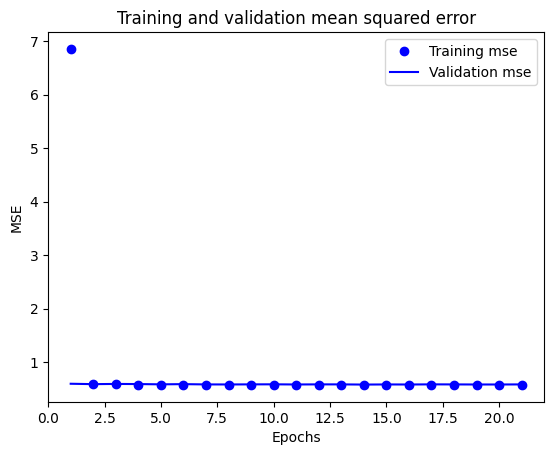


Performance on test set for model_9_4:
Best model loss : 0.5670957565307617

Done with model_9_4.
-----------------------------------------------------
Loading data for model_9_5...
P_matrices shape: (59992, 5, 4)
m_heights shape: (59992, 4)
Range of m_heights:
Min: [   6.3078012   59.612354   217.01117   1291.7003   ]
Max: [4.2418826e+02 5.4309243e+03 4.0550069e+05 2.9340678e+08]

Generating dataset for model_9_5...
Range of log m_heights in training data:
Min: [1.8417871 4.087863  5.3799486 7.163715 ]
Max: [ 6.0501776  8.599865  12.912878  19.49707  ]
Train dataset shape: (291552, 5, 4) (291552, 4)
Validation dataset shape: (5400, 5, 4) (5400, 4)
Test dataset shape: (6000, 5, 4) (6000, 4)

Compiling model for model_9_5...
Model compiled.

Training model for model_9_5...

Evaluating model for model_9_5...
Train MSE : [3.633114814758301, 0.5731589198112488, 0.568832516670227, 0.5669155716896057, 0.5655038356781006, 0.5647780299186707, 0.5639448761940002, 0.5632327795028687, 0.56285852

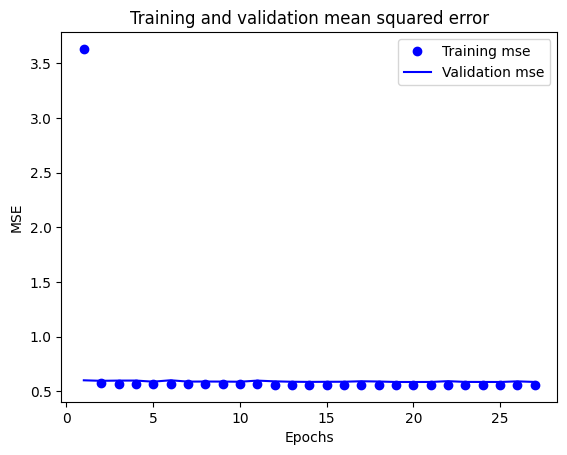


Performance on test set for model_9_5:
Best model loss : 0.5651624798774719

Done with model_9_5.
-----------------------------------------------------
Loading data for model_9_6...
P_matrices shape: (59998, 6, 3)
m_heights shape: (59998, 3)
Range of m_heights:
Min: [ 30.234015 179.31691  797.8311  ]
Max: [5.184621e+02 7.401902e+04 3.043078e+08]

Generating dataset for model_9_6...
Range of log m_heights in training data:
Min: [3.4089675 5.1891546 6.681897 ]
Max: [ 6.250867 11.212077 19.53355 ]
Train dataset shape: (291588, 6, 3) (291588, 3)
Validation dataset shape: (5400, 6, 3) (5400, 3)
Test dataset shape: (6000, 6, 3) (6000, 3)

Compiling model for model_9_6...
Model compiled.

Training model for model_9_6...

Evaluating model for model_9_6...
Train MSE : [5.110098838806152, 0.6508118510246277, 0.6436755657196045, 0.6407701373100281, 0.6384272575378418, 0.6365761160850525, 0.6354950070381165, 0.6347277164459229, 0.6331126093864441, 0.6321492195129395, 0.6316044330596924, 0.6312832

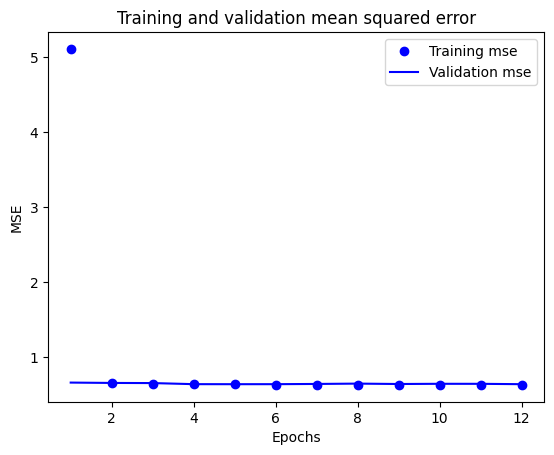


Performance on test set for model_9_6:
Best model loss : 0.61519455909729

Done with model_9_6.
-----------------------------------------------------
Loading data for model_10_4...
P_matrices shape: (34999, 4, 6)
m_heights shape: (34999, 6)
Range of m_heights:
Min: [   2.600804    7.893224   43.2334    124.328674  241.41588  1932.9349  ]
Max: [1.9218018e+02 2.9002396e+02 1.3718380e+03 8.4791533e+03 2.5119502e+05
 6.0206176e+08]

Generating dataset for model_10_4...
Range of log m_heights in training data:
Min: [0.9558207 2.14672   3.7666132 4.86294   5.4865212 7.566795 ]
Max: [ 5.1901255  5.6699634  7.2239065  9.045366  12.433985  20.21587  ]
Train dataset shape: (170094, 4, 6) (170094, 6)
Validation dataset shape: (3150, 4, 6) (3150, 6)
Test dataset shape: (3500, 4, 6) (3500, 6)

Compiling model for model_10_4...
Model compiled.

Training model for model_10_4...

Evaluating model for model_10_4...
Train MSE : [6.051126003265381, 0.5048061013221741, 0.5016435980796814, 0.5000633597373

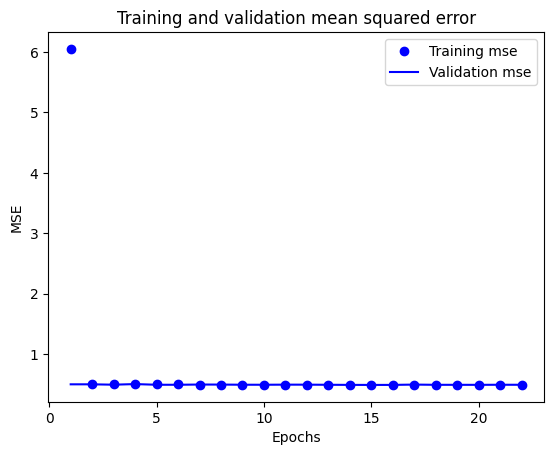


Performance on test set for model_10_4:
Best model loss : 0.5033398866653442

Done with model_10_4.
-----------------------------------------------------
Loading data for model_10_5...
P_matrices shape: (34996, 5, 5)
m_heights shape: (34996, 5)
Range of m_heights:
Min: [   5.340439   45.804024  135.14496   346.75046  3788.6633  ]
Max: [3.7719022e+02 1.4024301e+03 1.5339225e+04 6.0528188e+05 2.2121303e+09]

Generating dataset for model_10_5...
Range of log m_heights in training data:
Min: [1.6753079 4.1079607 4.9063478 5.848605  8.239769 ]
Max: [ 5.9327497  7.2459617  9.638168  13.31345   21.517221 ]
Train dataset shape: (170076, 5, 5) (170076, 5)
Validation dataset shape: (3150, 5, 5) (3150, 5)
Test dataset shape: (3500, 5, 5) (3500, 5)

Compiling model for model_10_5...
Model compiled.

Training model for model_10_5...

Evaluating model for model_10_5...
Train MSE : [6.601292133331299, 0.529483437538147, 0.5244017839431763, 0.5224037766456604, 0.5212169885635376, 0.5203642845153809, 

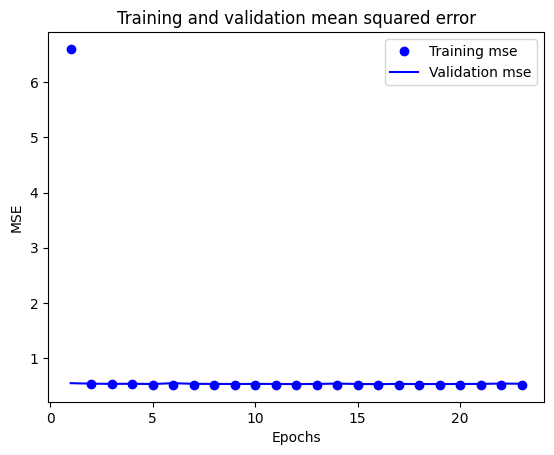


Performance on test set for model_10_5:
Best model loss : 0.5456448793411255

Done with model_10_5.
-----------------------------------------------------
Loading data for model_10_6...
P_matrices shape: (34993, 6, 4)
m_heights shape: (34993, 4)
Range of m_heights:
Min: [  19.954166  121.08272   301.86646  2049.033   ]
Max: [4.8236990e+02 8.1763545e+03 3.6380481e+05 1.4934546e+08]

Generating dataset for model_10_6...
Range of log m_heights in training data:
Min: [2.993438 4.796474 5.709985 7.625123]
Max: [ 6.1787114  9.009002  12.804373  18.821774 ]
Train dataset shape: (170058, 6, 4) (170058, 4)
Validation dataset shape: (3150, 6, 4) (3150, 4)
Test dataset shape: (3500, 6, 4) (3500, 4)

Compiling model for model_10_6...
Model compiled.

Training model for model_10_6...

Evaluating model for model_10_6...
Train MSE : [8.294920921325684, 0.5734747052192688, 0.5639321804046631, 0.559600293636322, 0.5565412044525146, 0.5554320812225342, 0.5536307096481323, 0.5520736575126648, 0.551342546

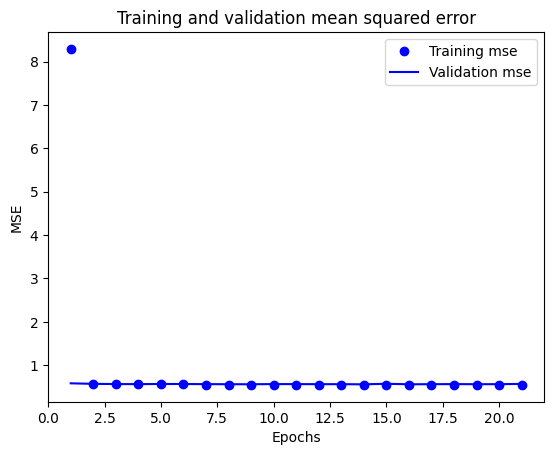


Performance on test set for model_10_6:
Best model loss : 0.5645021200180054

Done with model_10_6.
-----------------------------------------------------


In [10]:
model_save_directory = "."
val_split = 0.1
test_split = 0.1
num_permutations = 5
batch_size = 256
random_state = 4542
epochs = 40
patience = 7
train_verbosity = 0
for model_name, model_info in models_dict.items():
    filepath = samples_filepath + model_info['file_name']
    n = model_info['n']
    k = model_info['k']
    max_m_value = model_info['max_m_value']
    model_info['model'] = CustomModel(n=n, k=k, max_m_value=max_m_value)
    print(f"Loading data for model_{n}_{k}...")
    model_info['model'].load_and_preprocess_data(filepath)
    print(f"\nGenerating dataset for model_{n}_{k}...")
    model_info['model'].train_test_val_split(val_split=val_split, test_split=test_split, num_permutations=num_permutations, batch_size=batch_size, random_state=random_state)
    print(f"\nCompiling model for model_{n}_{k}...")
    model_info['model'].model_compile(build_model, print_summary=False)
    print(f"\nTraining model for model_{n}_{k}...")
    model_info['model'].model_train(epochs=epochs, verbose=train_verbosity, patience=patience, model_save_directory = model_save_directory)
    print(f"\nEvaluating model for model_{n}_{k}...")
    model_info['model'].plot_history()
    print(f"\nPerformance on test set for model_{n}_{k}:")
    model_info['model'].evaluate_model(batch_size=batch_size)
    print(f"\nDone with model_{n}_{k}.")
    print("-----------------------------------------------------")
# Rejigging my test dataset to input to the evaluator
eval_inputs_combined = {}
eval_outputs_combined = {}

for model_name, model_info in models_dict.items():
    for key in model_info['model'].eval_inputs.keys():
        if key not in eval_inputs_combined:
            eval_inputs_combined[key] = []
        eval_inputs_combined[key].extend(model_info['model'].eval_inputs[key])
    for key in model_info['model'].eval_outputs.keys():
        if key not in eval_outputs_combined:
            eval_outputs_combined[key] = []
        eval_outputs_combined[key].extend(model_info['model'].eval_outputs[key])

with gzip.open(model_save_directory+'/eval_inputs_combined', 'wb') as f:
            pickle.dump(eval_inputs_combined, f)
with gzip.open(model_save_directory+'/eval_outputs_combined', 'wb') as f:
            pickle.dump(eval_outputs_combined, f)



Testing using the evaluator framework

In [11]:
!pip install tamu_csce_636_project1

In [7]:
from tamu_csce_636_project1 import Evaluator
evaluator = Evaluator(
    first_name="Your Name",
    last_name="Your Name",
    email="email@tamu.edu",
    print=False,
)

In [2]:
def predict_and_evaluate(n,k,m,P_matrices):
    ## load model
    model_name = f'model_{n}_{k}.keras'
    model = tf.keras.models.load_model(model_name)
    m_heights = []
    P_matrices = np.array(P_matrices, dtype=np.float32)
    m_heights_pred = model.predict(P_matrices.reshape(len(P_matrices), k, n-k), verbose=0)
    m_heights =[np.exp(m_heights_pred[i][m-1]) for i in range(len(P_matrices))]
    return m_heights

In [16]:
!ls *.keras

model_10_4.keras  model_10_6.keras  model_9_5.keras
model_10_5.keras  model_9_4.keras   model_9_6.keras


In [15]:
with gzip.open('eval_inputs_combined', 'rb') as f:
    eval_inputs_combined = pickle.load(f)
with gzip.open('eval_outputs_combined', 'rb') as f:
    eval_outputs_combined = pickle.load(f)
σ = evaluator.eval(
        inputs=eval_inputs_combined,
        outputs=eval_outputs_combined,
        func=predict_and_evaluate,
    )
average_σ = sum(σ.values()) / len(σ) if σ else 0
print(f"Average σ: {average_σ}")
for key, value in σ.items():
    print(f"{key}, σ: {value}")

Average σ: 1.3191069255997578
(9, 4, 2), σ: 0.19257759396244892
(9, 4, 3), σ: 0.23654794669520127
(9, 4, 4), σ: 0.8287748458802048
(9, 4, 5), σ: 3.21858856430203
(9, 5, 2), σ: 0.2258321428314255
(9, 5, 3), σ: 0.7917963745291468
(9, 5, 4), σ: 3.40777544025823
(9, 6, 2), σ: 0.5275553278818856
(9, 6, 3), σ: 3.195237988734329
(10, 4, 2), σ: 0.8622887550641651
(10, 4, 3), σ: 0.09877091627186581
(10, 4, 4), σ: 0.26657844190349617
(10, 4, 5), σ: 0.9087587619962072
(10, 4, 6), σ: 3.4365835667935136
(10, 5, 2), σ: 0.12035170290111862
(10, 5, 3), σ: 0.3204983237806195
(10, 5, 4), σ: 0.8837275020322419
(10, 5, 5), σ: 3.6440490500348792
(10, 6, 2), σ: 0.22821722855585624
(10, 6, 3), σ: 0.8270504646344283
(10, 6, 4), σ: 3.479684498551624


##3. Submission


Packages used

In [ ]:
# To solve LPs
import numpy as np
import math
import pickle
import gzip
import os
import sys
from concurrent.futures import ProcessPoolExecutor
from itertools import combinations, product
from ortools.linear_solver import pywraplp
import time

#Training
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pickle
import gzip
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Function to generate m_heights for a list of P_matrices for a given n,k,m combination

In [3]:
def predict_and_evaluate(n,k,m,P_matrices):
    ## load model
    model_name = f'model_{n}_{k}.keras'
    model = tf.keras.models.load_model(model_name)
    m_heights = []
    P_matrices = np.array(P_matrices, dtype=np.float32)
    m_heights_pred = model.predict(P_matrices.reshape(len(P_matrices), k, n-k), verbose=0)
    # Pick the m-height from th elist of all m-heights predicted for each P
    m_heights =[np.exp(m_heights_pred[i][m-1]) for i in range(len(P_matrices))]
    return m_heights